In [1]:
import BioSimSpace as BSS


Sending anonymous Sire usage statistics to http://siremol.org.
For more information, see http://siremol.org/analytics
To disable, set the environment variable 'SIRE_DONT_PHONEHOME' to 1
To see the information sent, set the environment variable 
SIRE_VERBOSE_PHONEHOME equal to 1. To silence this message, set
the environment variable SIRE_SILENT_PHONEHOME to 1.



### Create Solvated System

In [2]:
mif_protein_dry = BSS.IO.readMolecules(["input/mif_protein.parm7","input/mif_protein.rst7"])

In [3]:
ligand = BSS.IO.readMolecules(["input/mif180_ligand.prm7","input/mif180_ligand.rst7"])

In [44]:
system = mif_protein_dry + ligand

In [45]:
view = BSS.Notebook.View(system)
view.system()

NGLWidget(gui_style='ngl')

In [8]:
# Get the minimium and maximum coordinates of the bounding box that
# minimally encloses the protein.
box_min, box_max = system.getAxisAlignedBoundingBox()

# Work out the box size from the difference in the coordinates.
box_size = [y - x for x, y in zip(box_min, box_max)]

# How much to pad each side of the protein? (Nonbonded cutoff = 10 A)
padding = 15 * BSS.Units.Length.angstrom

# Work out an appropriate box. This will used in each dimension to ensure
# that the cutoff constraints are satisfied if the molecule rotates.
box_length = max(box_size) + 2*padding

In [9]:
system_solvated = BSS.Solvent.tip3p(molecule=system, box=3*[box_length], ion_conc = 0.15)

In [12]:
view = BSS.Notebook.View(system_solvated)
view.system()

NGLWidget(gui_style='ngl')

## Minimisation

In [13]:
minimisation_protocol = BSS.Protocol.Minimisation(steps = 1000)

In [14]:
minimisation_process = BSS.Process.Amber(system_solvated, minimisation_protocol, exe = '/home/finlayclark/software/amber20/bin/pmemd')

In [15]:
minimisation_process.start()

BioSimSpace.Process.Amber(<BioSimSpace.System: nMolecules=17322>, BioSimSpace.Protocol.Minimisation(steps=1000), exe='/home/finlayclark/software/amber20/bin/pmemd', name='amber', work_dir='/tmp/tmp9w8fw2aa', seed=None)

In [48]:
minimisation_process.isRunning()

False

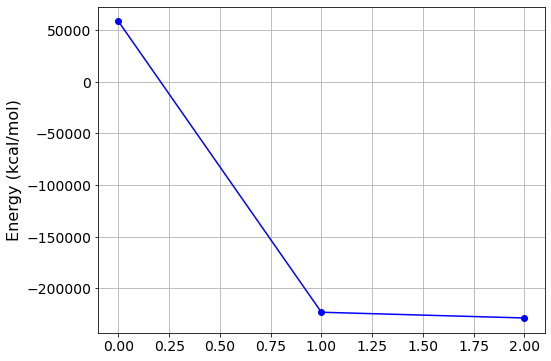

In [49]:
# Generate a plot of time vs energy.
plot = BSS.Notebook.plot(minimisation_process.getTime(time_series=True), minimisation_process.getTotalEnergy(time_series=True))

In [29]:
system_solvated_minimised = minimisation_process.getSystem(block=True)

In [30]:
BSS.IO.saveMolecules("system_solvated_minimised", system_solvated_minimised, ["prm7", "rst7","pdb"])

['/home/finlayclark/Documents/research/restraint_comparison_mif/testing/somd_tut/system_solvated_minimised.prm7',
 '/home/finlayclark/Documents/research/restraint_comparison_mif/testing/somd_tut/system_solvated_minimised.rst7',
 '/home/finlayclark/Documents/research/restraint_comparison_mif/testing/somd_tut/system_solvated_minimised.pdb']

## Equilibration

#### PMEMD NVT equilibration for 5 ps while restraining all non-solvent atoms

In [31]:
equil1_protocol = BSS.Protocol.Equilibration(
                                runtime=5*BSS.Units.Time.picosecond, 
                                temperature_start=0*BSS.Units.Temperature.kelvin, 
                                temperature_end=300*BSS.Units.Temperature.kelvin,
                                restraint="all"
                                )

In [32]:
equil1_process = BSS.Process.Amber(system_solvated_minimised, equil1_protocol, exe = '/home/finlayclark/software/amber20/bin/pmemd')

In [46]:
equil1_process.start()

BioSimSpace.Process.Amber(<BioSimSpace.System: nMolecules=17322>, BioSimSpace.Protocol.Equilibration(timestep=2.0000 fs, runtime=5.0000 ps, temperature_start=0.0100 K, temperature_end=300.0000 K, pressure=None, report_interval=100, restart_interval=500, restraint='all'), exe='/home/finlayclark/software/amber20/bin/pmemd', name='amber', work_dir='/tmp/tmpjcjj5d70', seed=None)

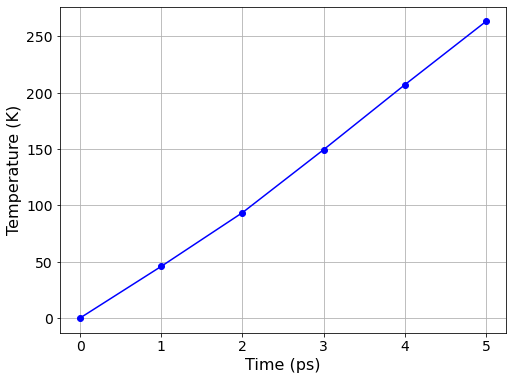

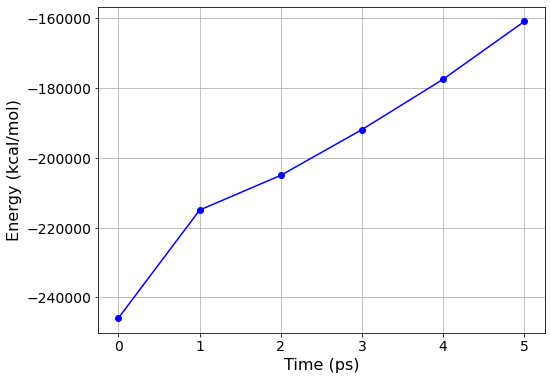

In [54]:
# Generate a plot of time vs temperature.
plot1 = BSS.Notebook.plot(equil1_process.getTime(time_series=True), equil1_process.getTemperature(time_series=True))

# Generate a plot of time vs energy.
plot2 = BSS.Notebook.plot(equil1_process.getTime(time_series=True), equil1_process.getTotalEnergy(time_series=True))

In [53]:
system_equil1 = equil1_process.getSystem(block=True)

#### PMEMD NVT equilibration for 50 ps while restraining all backbone atoms

In [55]:
equil2_protocol = BSS.Protocol.Equilibration(
                                runtime=5*BSS.Units.Time.picosecond, 
                                temperature=300*BSS.Units.Temperature.kelvin, 
                                restraint="backbone"
                                )

In [56]:
equil2_process = BSS.Process.Amber(system_equil1, equil2_protocol, exe = '/home/finlayclark/software/amber20/bin/pmemd')

In [60]:
equil2_process.start()

True

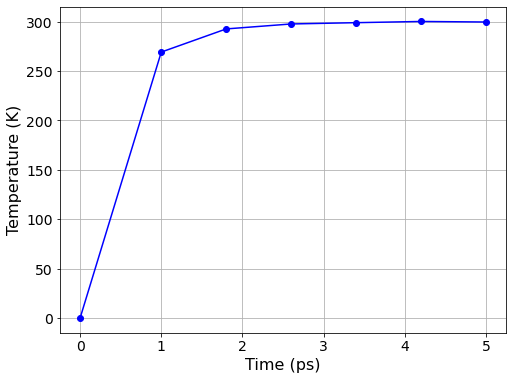

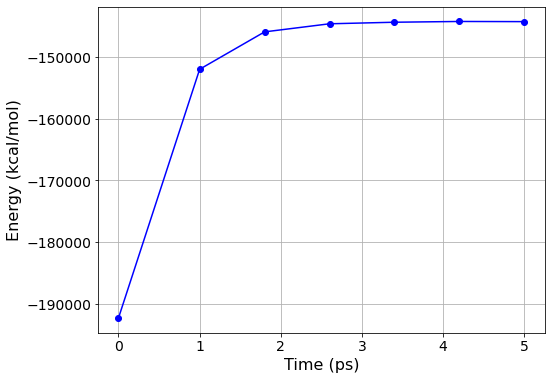

In [64]:
# Generate a plot of time vs temperature.
plot1 = BSS.Notebook.plot(equil2_process.getTime(time_series=True), equil2_process.getTemperature(time_series=True))

# Generate a plot of time vs energy.
plot2 = BSS.Notebook.plot(equil2_process.getTime(time_series=True), equil2_process.getTotalEnergy(time_series=True))

In [63]:
system_equil2 = equil2_process.getSystem(block=True)

#### PMEMD NVT equilibration for 5 ps without restraints

In [65]:
equil3_protocol = BSS.Protocol.Equilibration(
                                runtime=5*BSS.Units.Time.picosecond, 
                                temperature_end=300*BSS.Units.Temperature.kelvin,
                                )

In [66]:
equil3_process = BSS.Process.Amber(system_equil2, equil3_protocol, exe = '/home/finlayclark/software/amber20/bin/pmemd')

In [67]:
equil3_process.start()

BioSimSpace.Process.Amber(<BioSimSpace.System: nMolecules=17322>, BioSimSpace.Protocol.Equilibration(timestep=2.0000 fs, runtime=5.0000 ps, temperature_start=300.0000 K, temperature_end=300.0000 K, pressure=None, report_interval=100, restart_interval=500, restraint=None), exe='/home/finlayclark/software/amber20/bin/pmemd', name='amber', work_dir='/tmp/tmpa88mxiuu', seed=None)

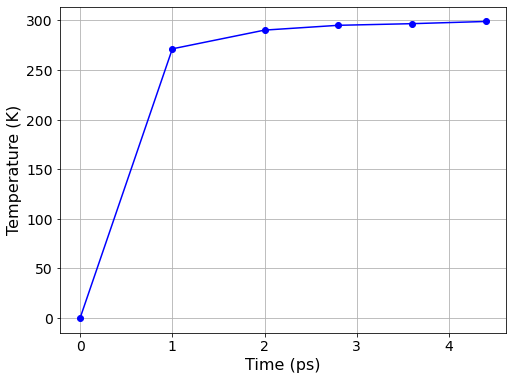

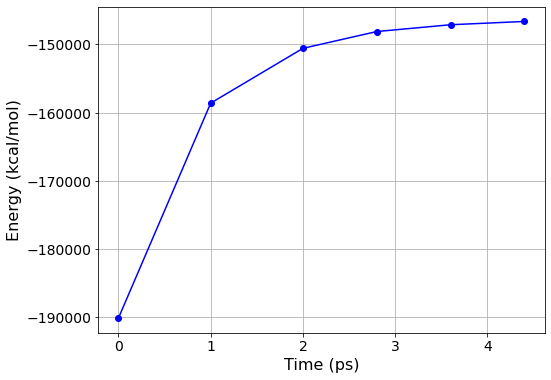

In [70]:
# Generate a plot of time vs temperature.
plot1 = BSS.Notebook.plot(equil3_process.getTime(time_series=True), equil3_process.getTemperature(time_series=True))

# Generate a plot of time vs energy.
plot2 = BSS.Notebook.plot(equil3_process.getTime(time_series=True), equil3_process.getTotalEnergy(time_series=True))

In [69]:
system_equil3 = equil3_process.getSystem(block=True)

#### PMEMD NPT equilibration for 400 ps while restraing non-solvent heavy atoms

In [76]:
equil4_protocol = BSS.Protocol.Equilibration(
                                runtime=400*BSS.Units.Time.picosecond, 
                                pressure=1*BSS.Units.Pressure.atm,
                                temperature=300*BSS.Units.Temperature.kelvin,
                                restraint="heavy",
                                )

In [77]:
equil4_process = BSS.Process.Amber(system_equil3, equil4_protocol, exe = '/home/finlayclark/software/amber20/bin/pmemd.cuda')

In [79]:
equil4_process.start()

BioSimSpace.Process.Amber(<BioSimSpace.System: nMolecules=17322>, BioSimSpace.Protocol.Equilibration(timestep=2.0000 fs, runtime=400.0000 ps, temperature_start=300.0000 K, temperature_end=300.0000 K, pressure=1.0000 atm, report_interval=100, restart_interval=500, restraint='heavy'), exe='/home/finlayclark/software/amber20/bin/pmemd.cuda', name='amber', work_dir='/tmp/tmp0qwctpc1', seed=None)

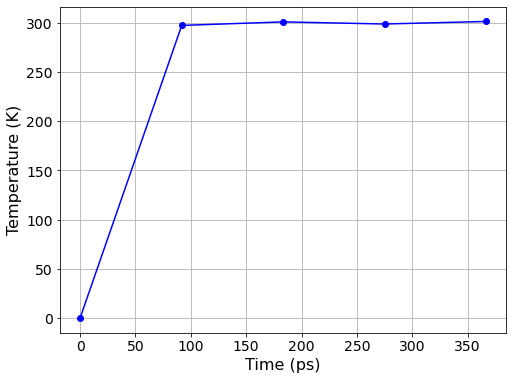

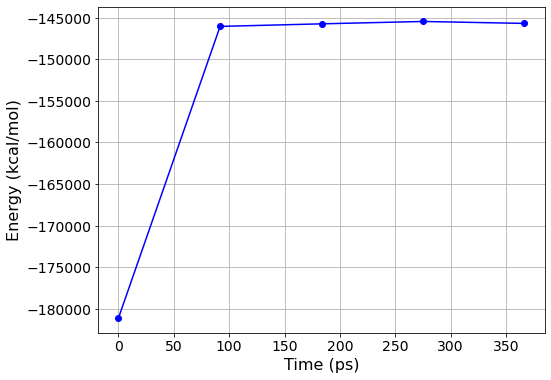

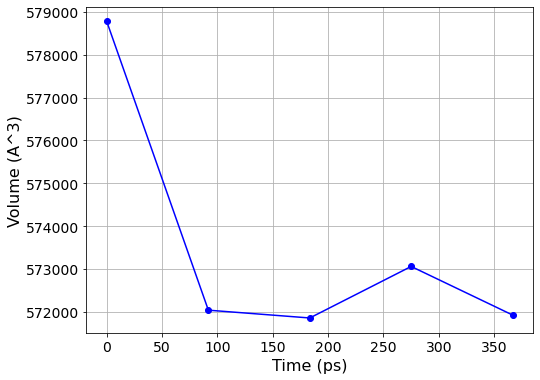

In [83]:
# Generate a plot of time vs temperature.
plot1 = BSS.Notebook.plot(equil4_process.getTime(time_series=True), equil4_process.getTemperature(time_series=True))

# Generate a plot of time vs energy.
plot2 = BSS.Notebook.plot(equil4_process.getTime(time_series=True), equil4_process.getTotalEnergy(time_series=True))

# Generate a plot of time vs volume.
plot2 = BSS.Notebook.plot(equil4_process.getTime(time_series=True), equil4_process.getVolume(time_series=True))

In [84]:
system_equil4 = equil4_process.getSystem(block=True)

In [89]:
view = BSS.Notebook.View(system_equil4)
view.system()

NGLWidget(gui_style='ngl')

#### PMEMD NPT equilibration for 400 ps without restraints

In [85]:
equil5_protocol = BSS.Protocol.Equilibration(
                                runtime=400*BSS.Units.Time.picosecond, 
                                pressure=1*BSS.Units.Pressure.atm,
                                temperature=300*BSS.Units.Temperature.kelvin)

In [86]:
equil5_process = BSS.Process.Amber(system_equil4, equil5_protocol, exe = '/home/finlayclark/software/amber20/bin/pmemd.cuda')

In [87]:
equil5_process.start()

BioSimSpace.Process.Amber(<BioSimSpace.System: nMolecules=17322>, BioSimSpace.Protocol.Equilibration(timestep=2.0000 fs, runtime=400.0000 ps, temperature_start=300.0000 K, temperature_end=300.0000 K, pressure=1.0000 atm, report_interval=100, restart_interval=500, restraint=None), exe='/home/finlayclark/software/amber20/bin/pmemd.cuda', name='amber', work_dir='/tmp/tmpu0yc0pe5', seed=None)

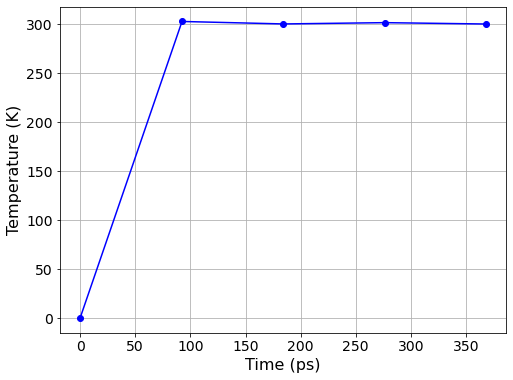

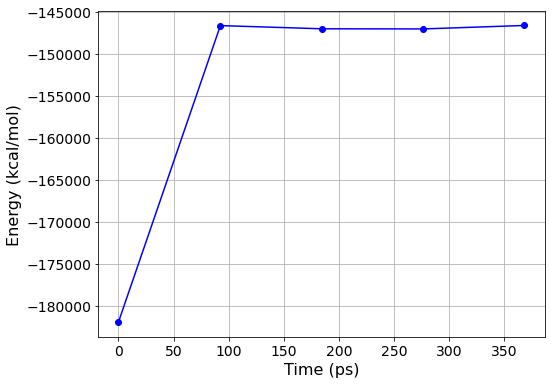

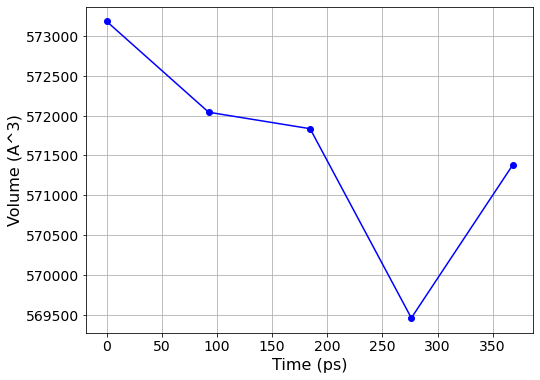

In [90]:
# Generate a plot of time vs temperature.
plot1 = BSS.Notebook.plot(equil5_process.getTime(time_series=True), equil5_process.getTemperature(time_series=True))

# Generate a plot of time vs energy.
plot2 = BSS.Notebook.plot(equil5_process.getTime(time_series=True), equil5_process.getTotalEnergy(time_series=True))

# Generate a plot of time vs volume.
plot2 = BSS.Notebook.plot(equil5_process.getTime(time_series=True), equil5_process.getVolume(time_series=True))

In [91]:
system_equil_final = equil5_process.getSystem(block=True)

In [92]:
BSS.IO.saveMolecules("system_equilibrated", system_equil_final, ["prm7", "rst7", "pdb"])

['/home/finlayclark/Documents/research/restraint_comparison_mif/testing/somd_tut/system_equilibrated.prm7',
 '/home/finlayclark/Documents/research/restraint_comparison_mif/testing/somd_tut/system_equilibrated.rst7',
 '/home/finlayclark/Documents/research/restraint_comparison_mif/testing/somd_tut/system_equilibrated.pdb']

In [103]:
view = BSS.Notebook.View(system_equil_final)
view.system()

NGLWidget(gui_style='ngl')